# computing the structural performane indicators for the generated forms

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import cem_mini
from cem_mini import plot_cem_form
import json

In [2]:
import dataset

In [3]:
import math

def _check_form(form,ax,view, thickness_base=0.5, thickness_ratio=0.02):
    plot_cem_form(ax,form['coords'],form['edges'],form['forces'],view=view,thickness_base=thickness_base,thickness_ratio=thickness_ratio)

def check_forms(forms,axis='off',view='3D-45',titles=None, title_offset=None, rows=None, suptitle=None, figsize=None, fname=None):
    if type(forms) is list:
        if rows is None:
            rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        if figsize is None:
            figsize=8
            
        fig=plt.figure(figsize=(figsize,int(figsize/cols*rows)))
        
        show_title=type(titles) is list
        
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form(forms[i],ax,view, thickness_base=0.2, thickness_ratio=0.01)
            plt.axis(axis)
            if show_title:
                plt.title(titles[i],y=title_offset)
        if suptitle is not None:
            plt.suptitle(suptitle)
        
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(figsize,figsize))
        ax=plt.axes(projection='3d')
        _check_form(forms,ax,view)
        plt.axis(axis)
        if type(titles) is str:
            plt.title(titles,y=title_offset)
        if suptitle is not None:
            plt.suptitle(suptitle)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [4]:
cem_dataset=dataset.get_dataset_from_file(r'..\..\cem pierluigi\SDML_CEM.py')

### CEM generator for tower dataset

adding additional indexing information to the dataset<br>
(i.e., which column of the CSV file corresponds to which floor / trail edges etc.)

In [5]:
# for tower dataset only
# add feature names which get node_xyz by floors
floor_num=10
node_per_floor=16
dev_edge_per_floor=24

trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()

In [6]:
trail_length_per_path=[[cem_dataset.name_dict['trail_length'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]
trail_mag_per_path=[[cem_dataset.name_dict['trail_mag'][to_trail_edge_indice(i,j)] for j in range(floor_num)] for i in range(node_per_floor)]

node_x_per_path=[[cem_dataset.name_dict['node_x'][i] for i in t] for t in trail_path]
node_y_per_path=[[cem_dataset.name_dict['node_y'][i] for i in t] for t in trail_path]
node_z_per_path=[[cem_dataset.name_dict['node_z'][i] for i in t] for t in trail_path]

node_x_by_floor=[cem_dataset.name_dict['node_x'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_y_by_floor=[cem_dataset.name_dict['node_y'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]
node_z_by_floor=[cem_dataset.name_dict['node_z'][i*node_per_floor:i*node_per_floor+node_per_floor] for i in range(floor_num+1)]

dev_mag_by_floor=[cem_dataset.name_dict['dev_mag'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]
dev_length_by_floor=[cem_dataset.name_dict['dev_length'][i*dev_edge_per_floor:i*dev_edge_per_floor+dev_edge_per_floor] for i in range(floor_num)]

In [7]:
for i in range(floor_num+1):
    cem_dataset.name_dict['node_x_%d'%i]=node_x_by_floor[i]
    cem_dataset.name_dict['node_y_%d'%i]=node_y_by_floor[i]
    cem_dataset.name_dict['node_z_%d'%i]=node_z_by_floor[i]

for i in range(floor_num):
    cem_dataset.name_dict['dev_length_%d'%i]=dev_length_by_floor[i]
    cem_dataset.name_dict['dev_mag_%d'%i]=dev_mag_by_floor[i]

for i in range(node_per_floor):
    cem_dataset.name_dict['trail_length_%d'%i]=trail_length_per_path[i]
    cem_dataset.name_dict['trail_mag_%d'%i]=trail_mag_per_path[i]
    cem_dataset.name_dict['node_x_trail-%d'%i]=node_x_per_path[i]
    cem_dataset.name_dict['node_y_trail-%d'%i]=node_y_per_path[i]
    cem_dataset.name_dict['node_z_trail-%d'%i]=node_z_per_path[i]

In [8]:
x0_sample = cem_dataset.get_vector(0,'node_x_0')
x0_sample = x0_sample/x0_sample.max()

y0_sample = cem_dataset.get_vector(0,'node_y_0')
y0_sample = y0_sample/y0_sample.max()

def generate_node_xy(x_size,y_size,grid=3):
    '''
    generate the node_x_0 and node_y_0 from the input grid sizes
    
    this function will be used when varifying the generated input parameters
    '''
    return  x0_sample*grid*x_size, y0_sample*grid*y_size

def to_cem_mini_topology(trail_length_raw, deviation_mag_raw, node_x_raw, node_y_raw, node_z_raw, load_x=0, load_y=0, load_z=-10):
    '''
    a validation function which generates the form of SDML-CEM dataset, using CEM input parameters from the dataset
    
    the function should produce identical form as shown in the dataset
    
    this function can later be extended as the python-version generator to validat the input parameters proposed by the Text2Form engine
    '''
    # compute trail path (i.e., connect trail edges / segments to continuous path)
    trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()
    
    # assign trail length (with positive and negative signs)
#     trail_length_raw=cem_dataset.get_vector(which,'trail_length')
#     trail_mag_raw=np.sign(cem_dataset.get_vector(which,'trail_mag'))

    trail_mag_raw=np.full(trail_length_raw.shape,-1)

    trail_length=[[trail_length_raw[to_trail_edge_indice(i,j)] * trail_mag_raw[to_trail_edge_indice(i,j)] for j in range(len(trail_path[i])-1)] for i in range(len(trail_path))]
    
    # assign deviation force magnitudes (with positive and negative signs)
    deviation_mag=list(deviation_mag_raw) # list(cem_dataset.get_vector(which,'dev_mag'))
    
    # assign initial node positions
    node_xyz=np.asarray([node_x_raw, node_y_raw, node_z_raw]).T
    node_xyz={i:list(node_xyz[i]) for i in range(len(node_xyz))}
    
    # assign loads (uniform load on all nodes)
    load_xyz=[load_x,load_y,load_z]
    load_xyz={i:load_xyz for i in range(cem_dataset.node_num)}

    # generate the topology using cem-mini generator
    # note that: the CEM input parameters by SDML-CEM dataset has already been optimized
    # therefore, idential form should be obtained without the need of optimization process
    T=cem_mini.create_topology(cem_dataset.node_num)
    cem_mini.set_trail_paths(T, trail_path,trail_length)
    cem_mini.set_deviation_edges(T,deviation_edge,deviation_mag)
    cem_mini.set_original_node_positions(T,node_xyz)
    cem_mini.set_node_loads(T,load_xyz)

    # solve the CEM
    F, Fc= cem_mini.CEM(T,1e-6)
    F['forces']=F['edge_forces']
    
    return F, Fc

In [9]:
def get_CEM_form(raw_vector):
    '''
    get the CEM form from the NN prediction
    '''
    grid_size_x,grid_size_y = raw_vector[:2] # grid size prediction
    
    trail_length=raw_vector[2:][:160] # trail length prediction
    dev_mag=raw_vector[2:][160:] # dev mag prediction
    
    # 1st step: get initial node positions
    node_x, node_y = generate_node_xy(grid_size_x,grid_size_y)
    node_z = np.full(node_y.shape,45)

    # 2nd step: run CEM in python, get the form and force diagrams
    return to_cem_mini_topology(trail_length,dev_mag,node_x,node_y,node_z)

# load CEM design parameters (saved as CSV)

In [25]:
my_texts=["thin twisted", "thin simple", "thick heavy", "thick simple balanced"]
my_cem_inputs=[]

for t in my_texts:
    fname='../output_IASS2022/cem input predictions/%s.csv'%(t.replace(' ','-'))
    my_cem_inputs.append(np.loadtxt(fname, delimiter=","))

obtain the 3D form from CEM inputs

In [26]:
forms_and_forces=[[get_CEM_form(i) for i in inputs] for inputs in my_cem_inputs]

In [27]:
forces=[[b for _,b in i] for i in forms_and_forces]
forms=[[a for a,_ in i] for i in forms_and_forces]

check data

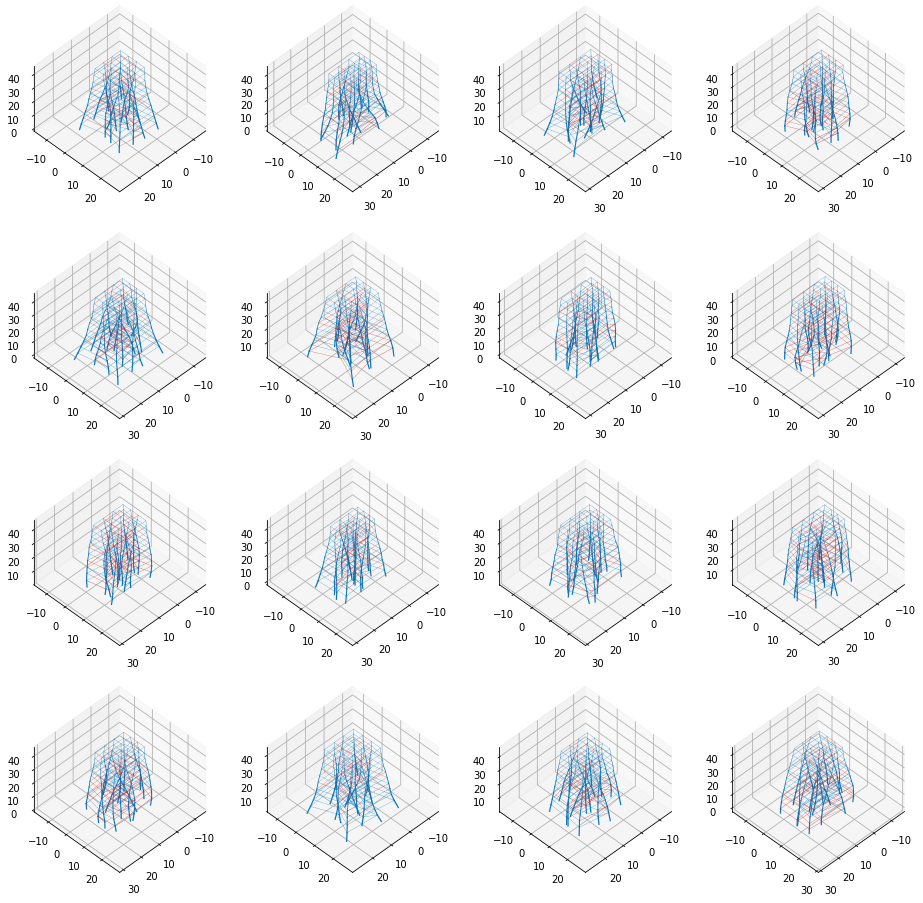

In [67]:
check_forms(forms[2],axis='on', figsize=16)

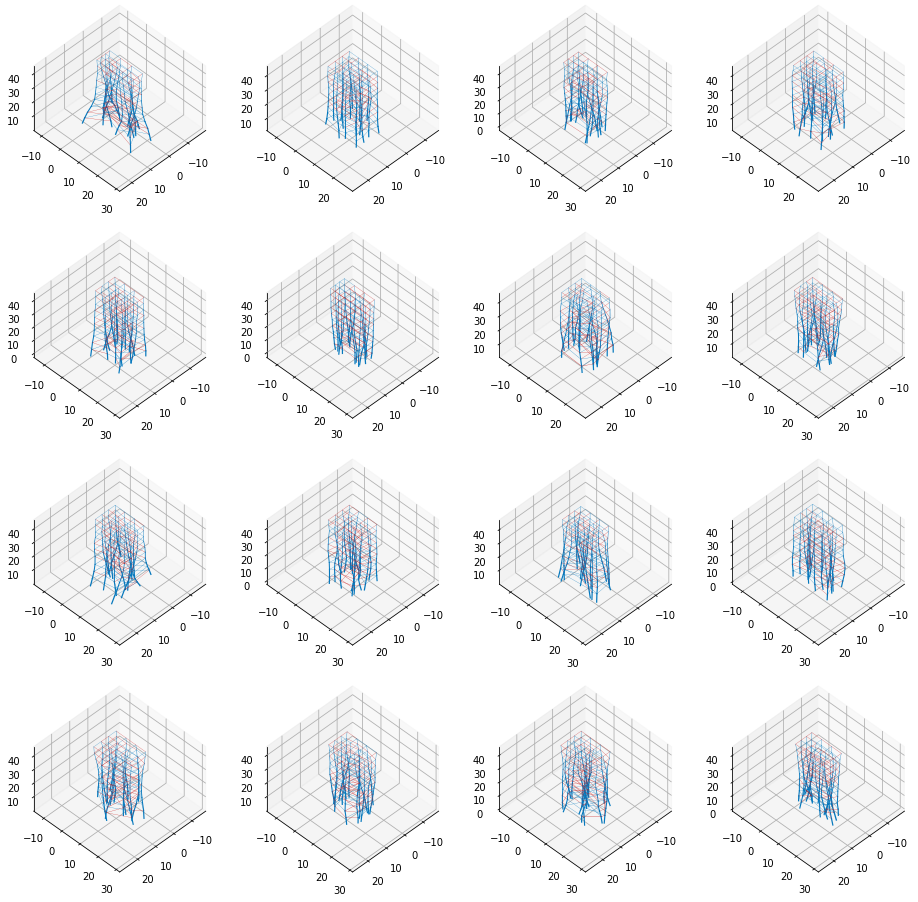

In [29]:
check_forms(forms[3],axis='on', figsize=16)

In [114]:
def tlp(form):
    '''
    compute the total loadpath of a 3d form
    '''
    coords = form['coords']
    edges = form['edges']
    starts = coords[[s for s,e in edges]]
    ends = coords[[e for s,e in edges]]
    
    dist = np.linalg.norm(starts - ends,axis=-1)
    
    f = np.abs(form['forces'])
    return (dist * f).sum()

In [115]:
min_forces = lambda x:np.array(x['forces']).min()
max_forces = lambda x:np.array(x['forces']).max()

In [95]:
metrics = [[{'min_force':min_forces(j), 'max_force':max_forces(j), 'tlp':tlp(j)} for j in i] for i in forms]

In [103]:
fmt = lambda x:f'{x:,.2f}' 
fmt(112314355.6857)

'112,314,355.69'

In [104]:
metrics_csv = [['min / max force %.2f / %.2f kN'%(min_forces(j), max_forces(j)) + ', total load path %s kNm'%fmt(tlp(j)) for j in i] for i in forms]

In [105]:
which=0
print(my_texts[which])
print("\n".join(metrics_csv[which]))

thin twisted
min / max force -107.67 / 6.98 kN, total load path 42,308.59 kNm
min / max force -109.64 / 9.17 kN, total load path 43,988.00 kNm
min / max force -136.58 / 12.01 kN, total load path 42,455.57 kNm
min / max force -121.65 / 8.31 kN, total load path 41,436.47 kNm
min / max force -109.70 / 3.78 kN, total load path 43,324.75 kNm
min / max force -108.63 / 8.31 kN, total load path 43,697.28 kNm
min / max force -122.15 / 8.82 kN, total load path 43,511.70 kNm
min / max force -108.85 / 8.74 kN, total load path 43,696.90 kNm
min / max force -108.77 / 7.08 kN, total load path 41,821.22 kNm
min / max force -110.01 / 7.85 kN, total load path 42,511.11 kNm
min / max force -114.44 / 7.48 kN, total load path 42,915.36 kNm
min / max force -108.26 / 6.86 kN, total load path 44,659.08 kNm
min / max force -114.33 / 11.13 kN, total load path 40,343.12 kNm
min / max force -111.75 / 7.83 kN, total load path 42,285.31 kNm
min / max force -107.39 / 4.14 kN, total load path 42,369.58 kNm
min / max 

In [106]:
which=1
print(my_texts[which])
print("\n".join(metrics_csv[which]))

thin simple
min / max force -115.53 / 11.37 kN, total load path 43,845.81 kNm
min / max force -104.96 / 5.83 kN, total load path 39,113.38 kNm
min / max force -112.08 / 7.67 kN, total load path 42,360.75 kNm
min / max force -109.86 / 5.92 kN, total load path 41,005.71 kNm
min / max force -109.52 / 7.06 kN, total load path 42,637.43 kNm
min / max force -109.65 / 8.50 kN, total load path 40,218.74 kNm
min / max force -106.50 / 10.07 kN, total load path 42,291.11 kNm
min / max force -103.62 / 10.15 kN, total load path 42,677.71 kNm
min / max force -105.01 / 7.45 kN, total load path 40,096.69 kNm
min / max force -116.37 / 10.52 kN, total load path 40,070.01 kNm
min / max force -109.86 / 9.59 kN, total load path 40,476.65 kNm
min / max force -110.48 / 3.66 kN, total load path 44,363.83 kNm
min / max force -105.82 / 9.94 kN, total load path 44,710.26 kNm
min / max force -104.90 / 6.56 kN, total load path 39,056.29 kNm
min / max force -118.90 / 10.50 kN, total load path 41,128.23 kNm
min / ma

In [107]:
which=2
print(my_texts[which])
print("\n".join(metrics_csv[which]))

thick heavy
min / max force -107.92 / 5.33 kN, total load path 41,554.84 kNm
min / max force -109.25 / 10.28 kN, total load path 48,306.78 kNm
min / max force -107.71 / 7.70 kN, total load path 42,626.38 kNm
min / max force -107.17 / 11.70 kN, total load path 42,929.93 kNm
min / max force -106.63 / 6.75 kN, total load path 45,841.61 kNm
min / max force -106.20 / 7.45 kN, total load path 43,504.65 kNm
min / max force -111.33 / 5.82 kN, total load path 42,279.52 kNm
min / max force -107.11 / 11.08 kN, total load path 42,710.40 kNm
min / max force -104.29 / 8.31 kN, total load path 42,117.51 kNm
min / max force -106.91 / 9.73 kN, total load path 43,109.46 kNm
min / max force -107.67 / 8.22 kN, total load path 41,685.52 kNm
min / max force -104.41 / 7.57 kN, total load path 44,045.43 kNm
min / max force -105.06 / 12.12 kN, total load path 44,083.75 kNm
min / max force -107.26 / 5.93 kN, total load path 43,070.41 kNm
min / max force -107.12 / 5.24 kN, total load path 42,802.81 kNm
min / max

In [108]:
which=3
print(my_texts[which])
print("\n".join(metrics_csv[which]))

thick simple balanced
min / max force -107.68 / 5.54 kN, total load path 40,210.20 kNm
min / max force -104.03 / 5.24 kN, total load path 39,949.40 kNm
min / max force -110.06 / 6.40 kN, total load path 41,498.59 kNm
min / max force -104.63 / 6.97 kN, total load path 41,308.76 kNm
min / max force -104.27 / 7.11 kN, total load path 42,202.67 kNm
min / max force -104.62 / 5.81 kN, total load path 41,927.22 kNm
min / max force -103.92 / 10.94 kN, total load path 41,210.14 kNm
min / max force -105.89 / 8.44 kN, total load path 40,330.60 kNm
min / max force -107.18 / 8.40 kN, total load path 43,741.97 kNm
min / max force -108.01 / 8.86 kN, total load path 42,602.66 kNm
min / max force -107.72 / 5.71 kN, total load path 42,722.29 kNm
min / max force -105.32 / 5.95 kN, total load path 41,236.59 kNm
min / max force -106.31 / 7.74 kN, total load path 42,235.78 kNm
min / max force -105.72 / 7.87 kN, total load path 41,135.79 kNm
min / max force -105.50 / 11.64 kN, total load path 42,887.13 kNm
m

In [111]:
sample_forms = cem_dataset.get_forms(range(16))

In [117]:
sample_metrics_csv = ['min / max force %.2f / %.2f kN'%(min_forces(j), max_forces(j)) + ', total load path %s kNm'%fmt(tlp(j)) for j in sample_forms]
sample_metrics_csv

['min / max force -101.99 / 5.00 kN, total load path 41,634.03 kNm',
 'min / max force -100.73 / 5.00 kN, total load path 42,111.88 kNm',
 'min / max force -100.90 / 5.00 kN, total load path 41,706.08 kNm',
 'min / max force -100.80 / 5.00 kN, total load path 39,194.18 kNm',
 'min / max force -100.79 / 5.00 kN, total load path 39,613.32 kNm',
 'min / max force -100.79 / 5.00 kN, total load path 46,071.50 kNm',
 'min / max force -101.85 / 5.00 kN, total load path 42,317.64 kNm',
 'min / max force -101.08 / 5.00 kN, total load path 40,702.66 kNm',
 'min / max force -100.75 / 5.00 kN, total load path 41,397.21 kNm',
 'min / max force -100.82 / 5.00 kN, total load path 44,448.20 kNm',
 'min / max force -103.13 / 5.00 kN, total load path 40,262.22 kNm',
 'min / max force -101.26 / 3.50 kN, total load path 40,940.65 kNm',
 'min / max force -101.64 / 5.00 kN, total load path 40,801.58 kNm',
 'min / max force -103.67 / 5.00 kN, total load path 42,612.02 kNm',
 'min / max force -100.22 / 5.00 k

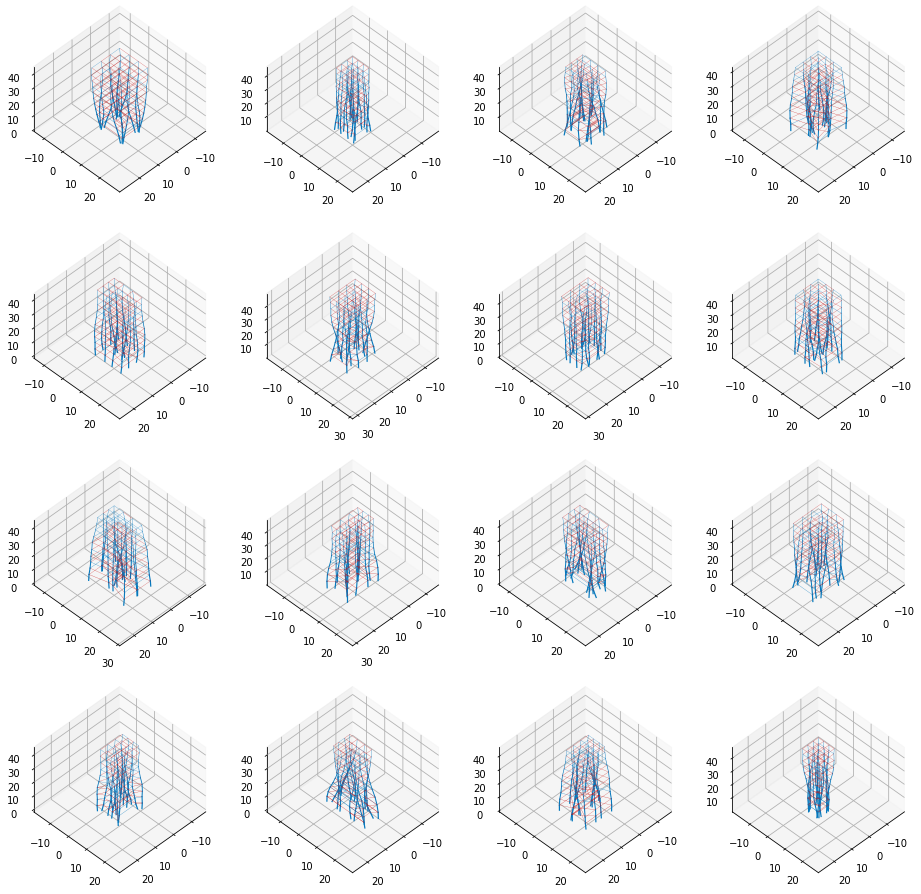

In [110]:
check_forms(cem_dataset.get_forms(range(16)),axis='on', figsize=16)